In [1]:
from petsc4py import PETSc
from mpi4py import MPI
import ufl
from dolfinx import mesh, fem
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc
import numpy
from petsc4py.PETSc import ScalarType  # type: ignore
t = 0  # Start time
T = 0.1  # End time
num_steps = 100  # Number of time steps
dt = (T - t) / num_steps  # Time step size
R = 5
h = 0.1
nx, ny = int(2*R/h), int(2*R/h)
domain = mesh.create_rectangle(comm=MPI.COMM_WORLD,
                            points=((-R, -R), (R, R)), n=(nx, ny),
                            cell_type=mesh.CellType.triangle)
V = fem.FunctionSpace(domain, ("Lagrange", 1))

tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)
boundary_facets = mesh.exterior_facet_indices(domain.topology)
dofs = fem.locate_dofs_topological(V, entity_dim=1, entities=boundary_facets)
bc = fem.dirichletbc(value=ScalarType(0), dofs=dofs, V=V)


In [2]:
class initial_condition():
    def __init__(self):
        pass
    def __call__(self, x):
        return numpy.exp(-10*(x[0]**2+x[1]**2))
u_init = initial_condition()
u_n = fem.Function(V)
u_n.interpolate(u_init)

class ax():
    def __init__(self):
        pass
    def __call__(self, x):
        return numpy.sin(x[0]) + numpy.sin(x[1])- 1/2*(x[0]**6+x[1]**6)
a_fun = ax()
a = fem.Function(V)
a.interpolate(a_fun)

class fx():
    def __init__(self):
        pass
    def __call__(self, x):
        return numpy.cos(x[0]) ,numpy.cos(x[1])
f_fun = fx()

v_2 = ufl.VectorElement("Lagrange", domain.ufl_cell(), 2)
V_2 = fem.FunctionSpace(domain, v_2)
f = fem.Function(V_2)
f.interpolate(f_fun)

In [3]:
u, v = ufl.TrialFunction(V), ufl.TestFunction(V)
F = u * v * ufl.dx + 1/2*dt * ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx + dt* ufl.dot(f,ufl.grad(u))*v* ufl.dx- dt*a*u*v*ufl.dx - u_n * v * ufl.dx
lhs = fem.form(ufl.lhs(F))
rhs = fem.form(ufl.rhs(F))
A = assemble_matrix(lhs, bcs=[bc])
A.assemble()
b = create_vector(rhs)

In [4]:
solver = PETSc.KSP().create(domain.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)


In [5]:
uh = fem.Function(V)
for n in range(num_steps):
    # Update Diriclet boundary condition
    # Update the right hand side reusing the initial vector
    with b.localForm() as loc_b:
        loc_b.set(0)
    assemble_vector(b, rhs)

    # Apply Dirichlet boundary condition to the vector
    apply_lifting(b, [lhs], [[bc]])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b, [bc])

    # Solve linear problem
    solver.solve(b, uh.vector)
    uh.x.scatter_forward()

    # Update solution at previous time step (u_n)
    u_n.x.array[:] = uh.x.array


In [6]:
from dolfinx import io, plot
with io.XDMFFile(domain.comm, "out_poisson/poisson.xdmf", "w") as file:
    file.write_mesh(domain)
    file.write_function(uh)


No module named 'trame'

Falling back to a static output.
  warnings.warn(



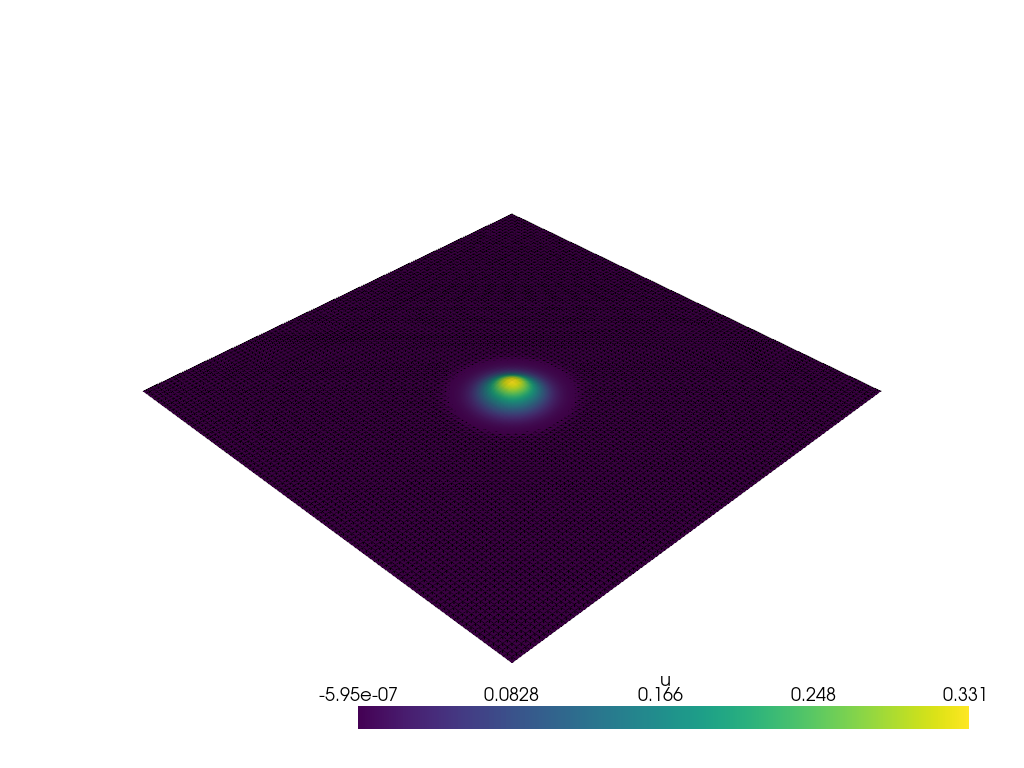

In [7]:
try:
    import pyvista
    cells, types, x = plot.vtk_mesh(V)
    grid = pyvista.UnstructuredGrid(cells, types, x)
    grid.point_data["u"] = uh.x.array.real
    grid.set_active_scalars("u")
    plotter = pyvista.Plotter()
    plotter.add_mesh(grid, show_edges=True)
    warped = grid.warp_by_scalar()
    plotter.add_mesh(warped)
    if pyvista.OFF_SCREEN:
        pyvista.start_xvfb(wait=0.1)
        plotter.screenshot("uh_poisson.png")
    else:
        plotter.show()
except ModuleNotFoundError:
    print("'pyvista' is required to visualise the solution")
    print("Install 'pyvista' with pip: 'python3 -m pip install pyvista'")


No module named 'trame'

Falling back to a static output.
  warnings.warn(



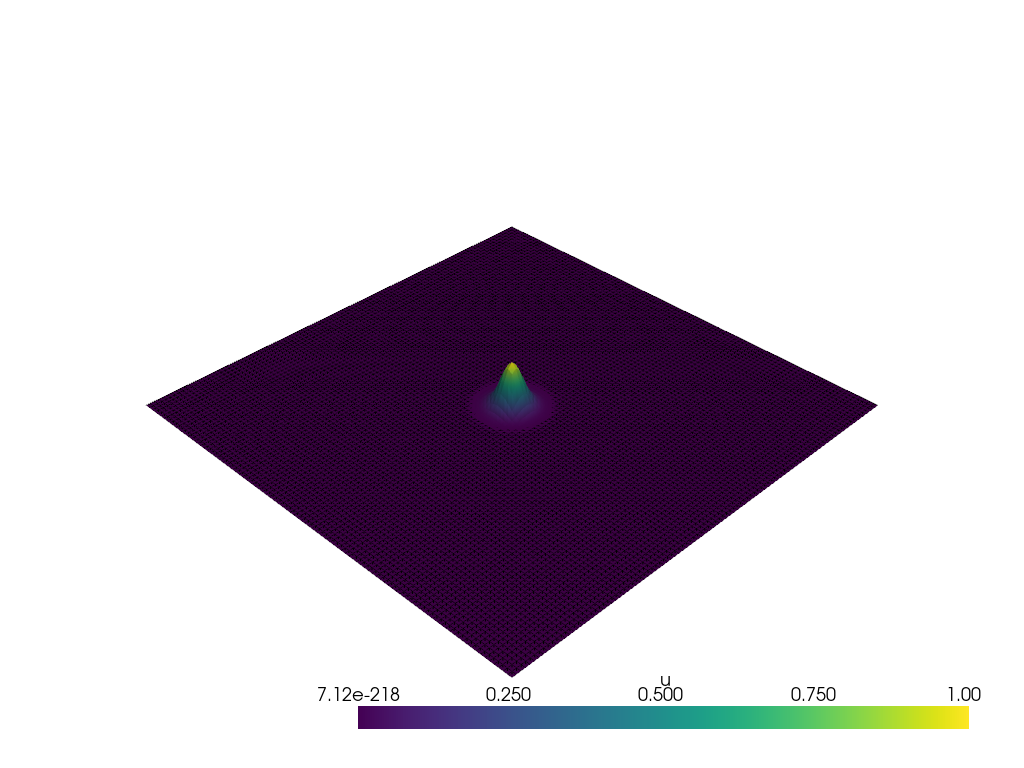

In [8]:
u_n1 = fem.Function(V)
u_n1.interpolate(u_init)
try:
    import pyvista
    cells, types, x = plot.vtk_mesh(V)
    grid = pyvista.UnstructuredGrid(cells, types, x)
    grid.point_data["u"] = u_n1.x.array.real
    grid.set_active_scalars("u")
    plotter = pyvista.Plotter()
    plotter.add_mesh(grid, show_edges=True)
    warped = grid.warp_by_scalar()
    plotter.add_mesh(warped)
    if pyvista.OFF_SCREEN:
        pyvista.start_xvfb(wait=0.1)
        plotter.screenshot("uh_poisson.png")
    else:
        plotter.show()
except ModuleNotFoundError:
    print("'pyvista' is required to visualise the solution")
    print("Install 'pyvista' with pip: 'python3 -m pip install pyvista'")